# BO2 — Détection de la Sévérité d'Alzheimer (Scanners IRM)
# Classification Multi-classes d'Images IRM Cérébrales

**Auteur :** TechHive  
**Date :** Février 2026  
**Projet :** Thynk Unlimited — We Learn For The Future

---

## Executive Summary

Ce notebook implémente le **Business Objective 2 (BO2)** du projet Alzheimer :  
**Graduation Clinique Automatisée** — Assister les radiologues en classant automatiquement  
la sévérité de la démence à partir des IRM pour prioriser les cas urgents (Triage).

**DSO :** Classer une image IRM d'entrée dans l'une des 4 catégories :
- **NonDemented** (Sain)
- **VeryMildDemented** (Très Léger)
- **MildDemented** (Léger)
- **ModerateDemented** (Modéré)

**Type de ML :** Apprentissage Supervisé → Classification d'Images Multi-classes  
**Dataset :** [Kaggle — Alzheimer's Dataset (4 class of Images)](https://www.kaggle.com/datasets/preetpalsingh25/alzheimers-dataset-4-class-of-images)

---

## Pipeline du Notebook

1. Configuration de l'environnement
2. Chargement et exploration des données (EDA)
3. Prétraitement & Augmentation de données
4. Construction des modèles (CNN Custom + Transfer Learning)

## 1. Configuration de l'Environnement

Installation et importation des bibliothèques nécessaires pour le deep learning,  
la manipulation d'images et la visualisation.

In [1]:
# ============================================================
# 1.1 Installation des dépendances (décommenter si nécessaire)
# ============================================================
# !pip install tensorflow matplotlib seaborn scikit-learn pillow

# ============================================================
# 1.2 Importations
# ============================================================

# Core
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Image processing
from PIL import Image
import cv2

# Deep Learning — TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score, roc_auc_score,
    precision_recall_curve, roc_curve
)
from sklearn.utils.class_weight import compute_class_weight

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("=" * 60)
print("ENVIRONMENT INFO")
print("=" * 60)
print(f"TensorFlow version : {tf.__version__}")
print(f"GPU disponible     : {tf.config.list_physical_devices('GPU')}")
print(f"NumPy version      : {np.__version__}")
print("=" * 60)

ENVIRONMENT INFO
TensorFlow version : 2.20.0
GPU disponible     : []
NumPy version      : 1.26.4


## 2. Chargement des Données

Le dataset est organisé en dossiers : `train/` et `test/`, chacun contenant  
4 sous-dossiers correspondant aux 4 classes de sévérité.

**Structure attendue :**
```
Alzheimer_s Dataset/
├── train/
│   ├── MildDemented/
│   ├── ModerateDemented/
│   ├── NonDemented/
│   └── VeryMildDemented/
└── test/
    ├── MildDemented/
    ├── ModerateDemented/
    ├── NonDemented/
    └── VeryMildDemented/
```

In [2]:
# ============================================================
# 2.1 Configuration des chemins
# ============================================================

# ⚠️ MODIFIER CE CHEMIN selon votre environnement
BASE_DIR = "Alzheimer_s Dataset"  # Chemin vers le dossier racine du dataset
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Paramètres d'image
IMG_SIZE = 224       # Taille cible (224x224 pour compatibilité Transfer Learning)
BATCH_SIZE = 32      # Taille de lot
NUM_CLASSES = 4      # Nombre de classes

# Noms des classes
CLASS_NAMES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
CLASS_LABELS_FR = {
    'MildDemented': 'Léger',
    'ModerateDemented': 'Modéré', 
    'NonDemented': 'Sain',
    'VeryMildDemented': 'Très Léger'
}

print(f"Dossier Train : {TRAIN_DIR}")
print(f"Dossier Test  : {TEST_DIR}")
print(f"Taille image  : {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size    : {BATCH_SIZE}")
print(f"Classes       : {CLASS_NAMES}")

Dossier Train : Alzheimer_s Dataset\train
Dossier Test  : Alzheimer_s Dataset\test
Taille image  : 224x224
Batch size    : 32
Classes       : ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [3]:
# ============================================================
# 2.2 Comptage et inventaire des images
# ============================================================

def count_images(directory):
    """Compte les images par classe dans un répertoire."""
    counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            n = len([f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
            counts[class_name] = n
    return counts

train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

# Construire le tableau récapitulatif
summary = pd.DataFrame({
    'Classe': list(train_counts.keys()),
    'Train': list(train_counts.values()),
    'Test': list(test_counts.values()),
})
summary['Total'] = summary['Train'] + summary['Test']
summary['% Train'] = (summary['Train'] / summary['Train'].sum() * 100).round(1)
summary['Label FR'] = summary['Classe'].map(CLASS_LABELS_FR)

print("=" * 70)
print("DISTRIBUTION DES IMAGES PAR CLASSE")
print("=" * 70)
print(summary.to_string(index=False))
print(f"\nTotal Train : {summary['Train'].sum():,}")
print(f"Total Test  : {summary['Test'].sum():,}")
print(f"Total       : {summary['Total'].sum():,}")
print("=" * 70)

DISTRIBUTION DES IMAGES PAR CLASSE
          Classe  Train  Test  Total  % Train   Label FR
    MildDemented    896   896   1792     14.0      Léger
ModerateDemented     64    64    128      1.0     Modéré
     NonDemented   3200  3200   6400     50.0       Sain
VeryMildDemented   2240  2240   4480     35.0 Très Léger

Total Train : 6,400
Total Test  : 6,400
Total       : 12,800


## 3. Analyse Exploratoire des Données (EDA)

Visualisation approfondie du dataset pour comprendre :
- La distribution des classes (déséquilibre)
- Les caractéristiques visuelles des images IRM
- Les différences entre les classes

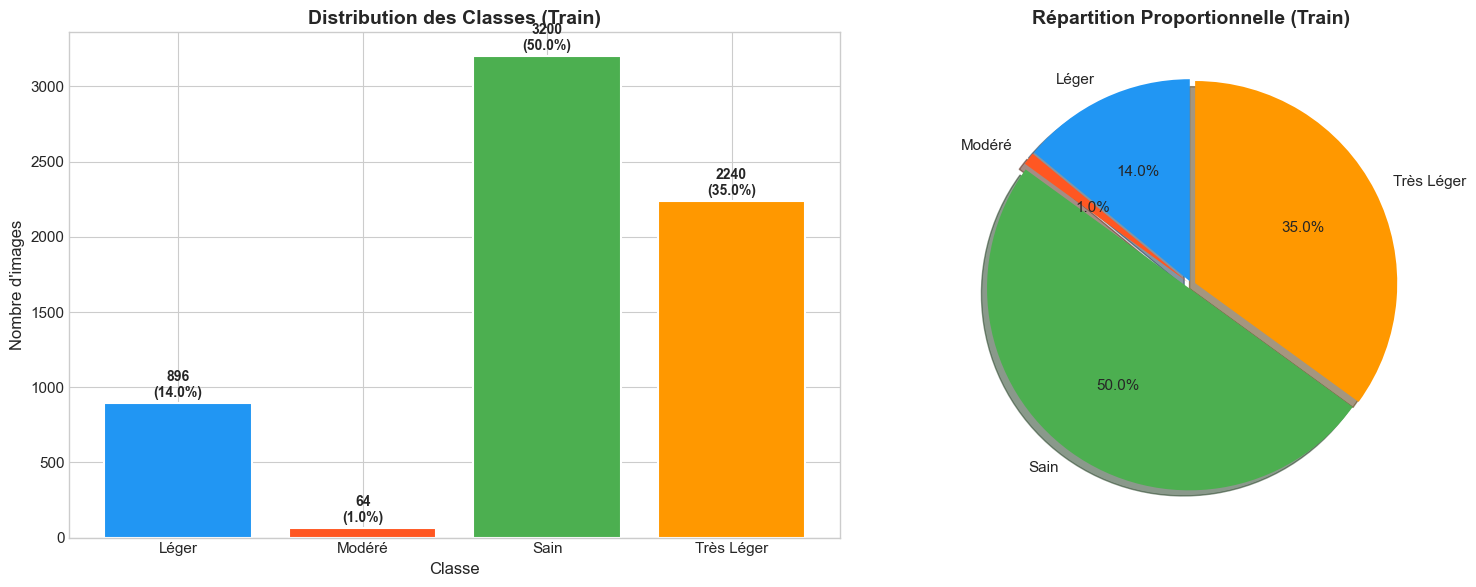


⚠️  DÉSÉQUILIBRE DÉTECTÉ :
   Classe majoritaire : NonDemented (3200 images)
   Classe minoritaire : ModerateDemented (64 images)
   Ratio déséquilibre : 50.0x


In [4]:
# ============================================================
# 3.1 Distribution des classes (Train)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
colors = ['#2196F3', '#FF5722', '#4CAF50', '#FF9800']
bars = axes[0].bar(summary['Label FR'], summary['Train'], color=colors, edgecolor='white', linewidth=1.5)
axes[0].set_title('Distribution des Classes (Train)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Nombre d\'images', fontsize=12)
axes[0].set_xlabel('Classe', fontsize=12)
for bar, count, pct in zip(bars, summary['Train'], summary['% Train']):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 20,
                f'{count}\n({pct}%)', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Pie chart
explode = [0.02] * 4
wedges, texts, autotexts = axes[1].pie(
    summary['Train'], labels=summary['Label FR'], autopct='%1.1f%%',
    colors=colors, explode=explode, shadow=True, startangle=90,
    textprops={'fontsize': 11}
)
axes[1].set_title('Répartition Proportionnelle (Train)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('01_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Alerte déséquilibre
max_class = summary.loc[summary['Train'].idxmax()]
min_class = summary.loc[summary['Train'].idxmin()]
ratio = max_class['Train'] / min_class['Train']
print(f"\n⚠️  DÉSÉQUILIBRE DÉTECTÉ :")
print(f"   Classe majoritaire : {max_class['Classe']} ({max_class['Train']} images)")
print(f"   Classe minoritaire : {min_class['Classe']} ({min_class['Train']} images)")
print(f"   Ratio déséquilibre : {ratio:.1f}x")

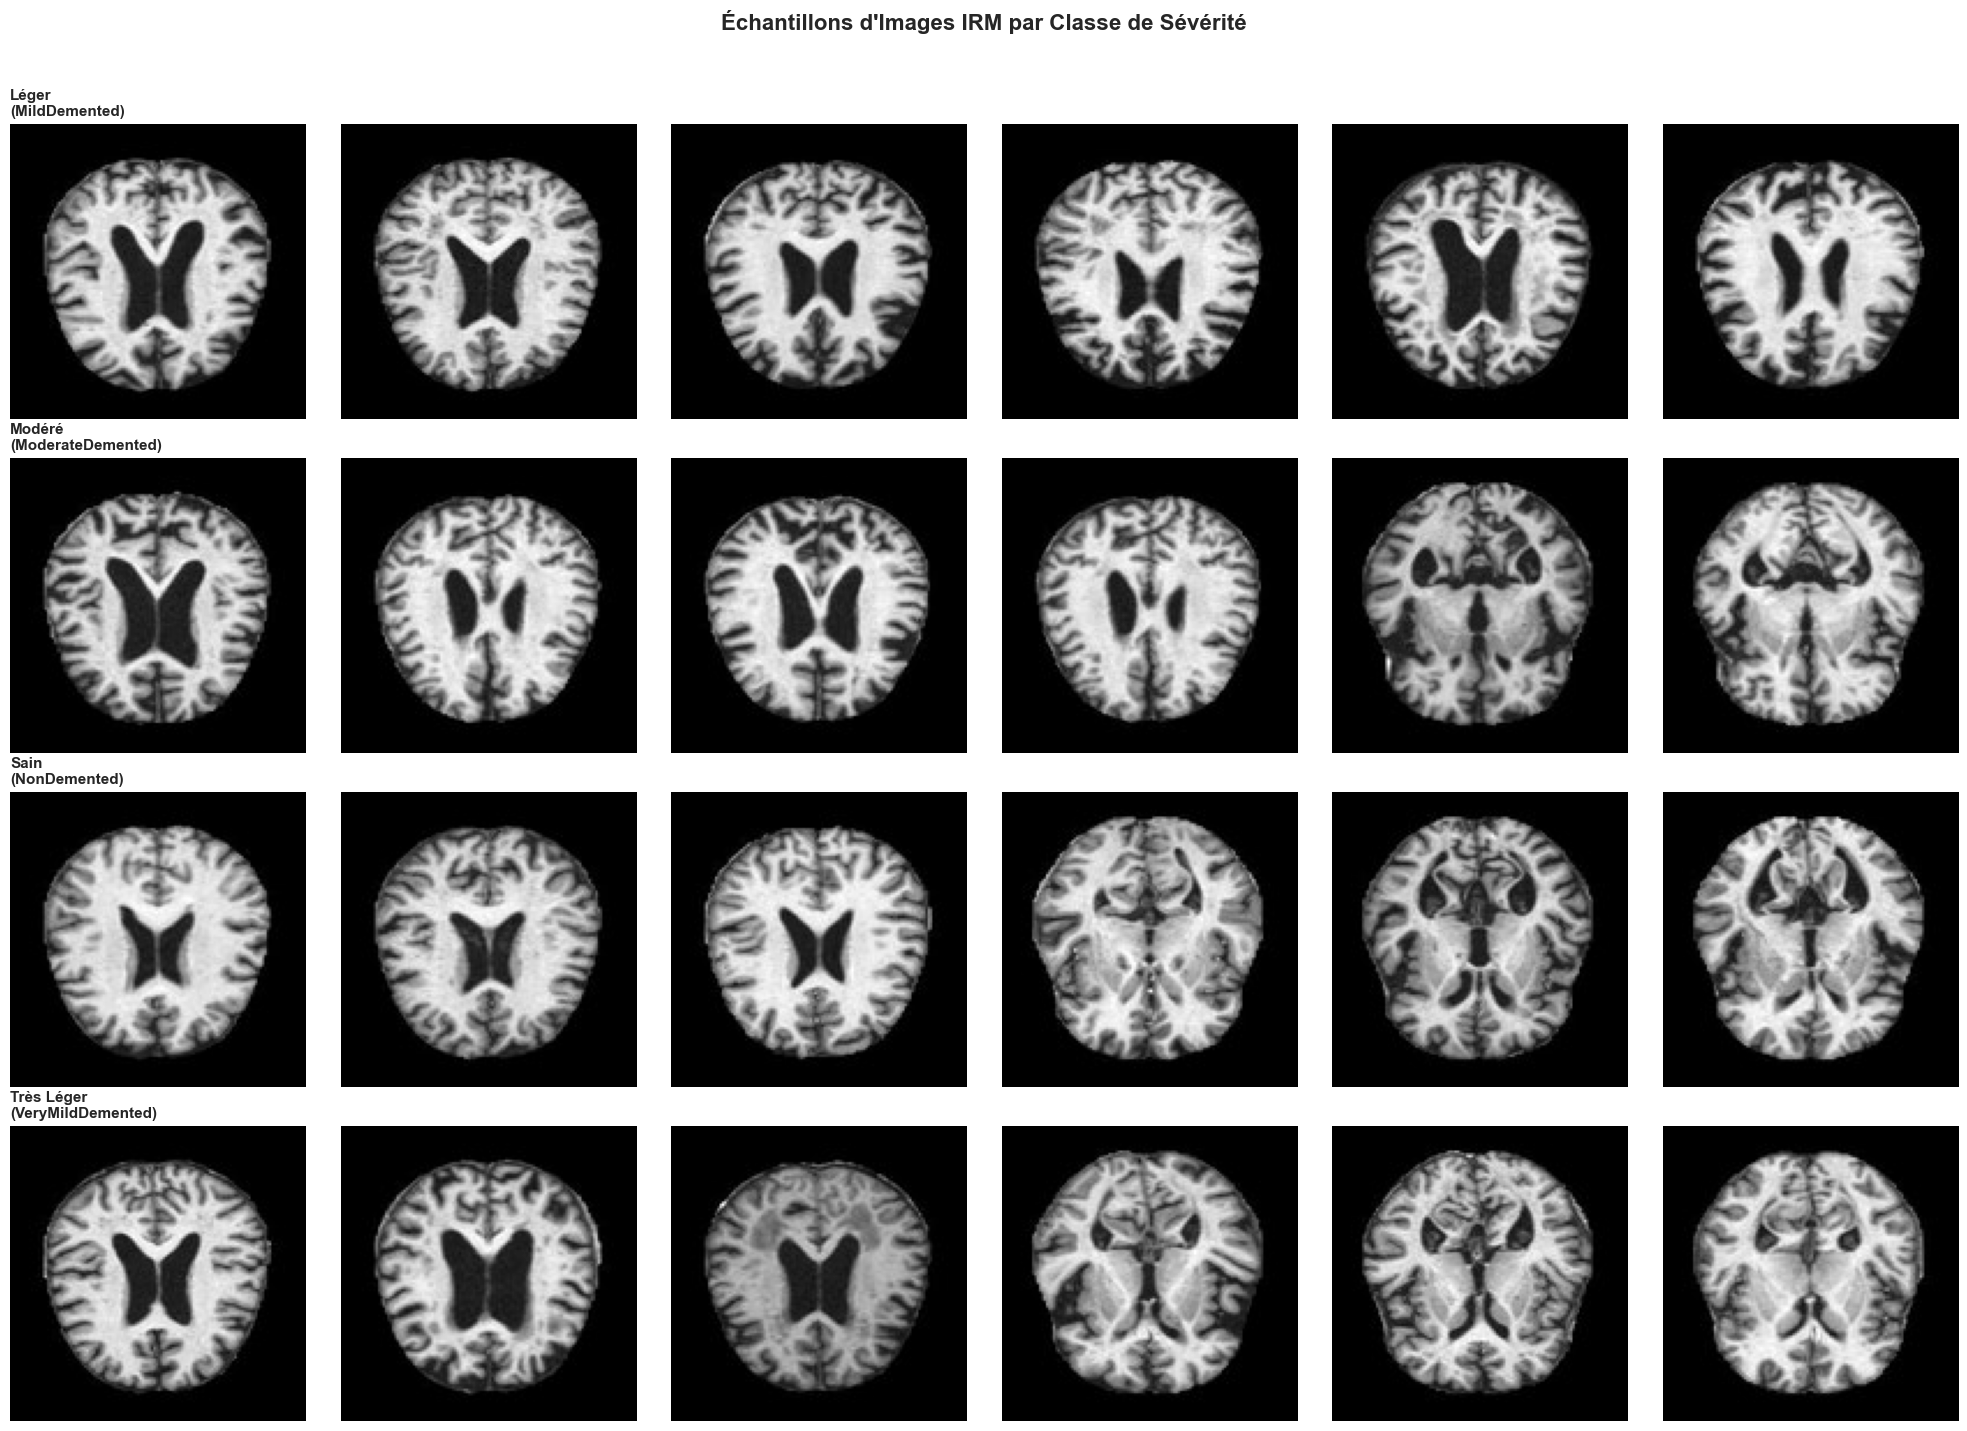

In [5]:
# ============================================================
# 3.2 Visualisation d'échantillons par classe
# ============================================================

fig, axes = plt.subplots(4, 6, figsize=(20, 14))
fig.suptitle("Échantillons d'Images IRM par Classe de Sévérité", 
             fontsize=16, fontweight='bold', y=1.02)

for row, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(TRAIN_DIR, class_name)
    images = sorted(os.listdir(class_path))[:6]
    
    for col, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(
                f"{CLASS_LABELS_FR[class_name]}\n({class_name})", 
                fontsize=11, fontweight='bold', loc='left'
            )

plt.tight_layout()
plt.savefig('02_sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# ============================================================
# 3.3 Statistiques des images (dimensions, pixels)
# ============================================================

def analyze_image_stats(directory, sample_per_class=100):
    """Analyse les statistiques d'images par classe."""
    stats = []
    for class_name in CLASS_NAMES:
        class_path = os.path.join(directory, class_name)
        files = os.listdir(class_path)[:sample_per_class]
        
        widths, heights, means, stds = [], [], [], []
        for f in files:
            try:
                img = Image.open(os.path.join(class_path, f))
                w, h = img.size
                img_arr = np.array(img).astype(np.float32)
                widths.append(w)
                heights.append(h)
                means.append(img_arr.mean())
                stds.append(img_arr.std())
            except:
                continue
        
        stats.append({
            'Classe': class_name,
            'Label': CLASS_LABELS_FR[class_name],
            'Nb échantillons': len(widths),
            'Largeur (mode)': max(set(widths), key=widths.count) if widths else 0,
            'Hauteur (mode)': max(set(heights), key=heights.count) if heights else 0,
            'Pixel Mean': np.mean(means),
            'Pixel Std': np.mean(stds),
        })
    return pd.DataFrame(stats)

img_stats = analyze_image_stats(TRAIN_DIR)
print("=" * 70)
print("STATISTIQUES DES IMAGES (Train)")
print("=" * 70)
print(img_stats.to_string(index=False))
print("=" * 70)

STATISTIQUES DES IMAGES (Train)
          Classe      Label  Nb échantillons  Largeur (mode)  Hauteur (mode)  Pixel Mean  Pixel Std
    MildDemented      Léger              100             128             128   65.553230  81.611946
ModerateDemented     Modéré               64             128             128   68.805267  82.164230
     NonDemented       Sain              100             128             128   73.009789  81.922295
VeryMildDemented Très Léger              100             128             128   69.421577  79.556351


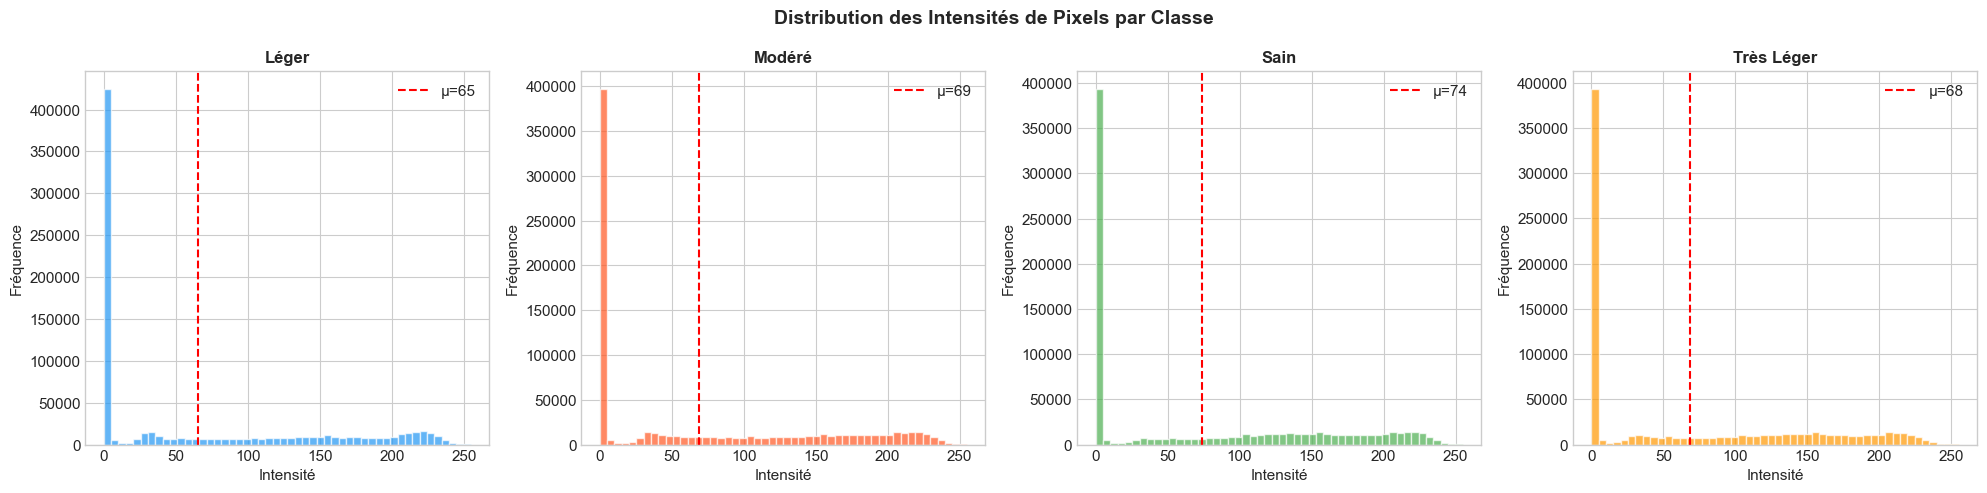

In [7]:
# ============================================================
# 3.4 Distribution des intensités de pixels par classe
# ============================================================

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Distribution des Intensités de Pixels par Classe", 
             fontsize=14, fontweight='bold')

colors_hist = ['#2196F3', '#FF5722', '#4CAF50', '#FF9800']

for idx, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(TRAIN_DIR, class_name)
    sample_files = os.listdir(class_path)[:50]
    
    all_pixels = []
    for f in sample_files:
        try:
            img = np.array(Image.open(os.path.join(class_path, f)).convert('L'))
            all_pixels.extend(img.flatten())
        except:
            continue
    
    axes[idx].hist(all_pixels, bins=50, color=colors_hist[idx], alpha=0.7, edgecolor='white')
    axes[idx].set_title(f"{CLASS_LABELS_FR[class_name]}", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Intensité')
    axes[idx].set_ylabel('Fréquence')
    axes[idx].axvline(np.mean(all_pixels), color='red', linestyle='--', label=f'μ={np.mean(all_pixels):.0f}')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('03_pixel_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

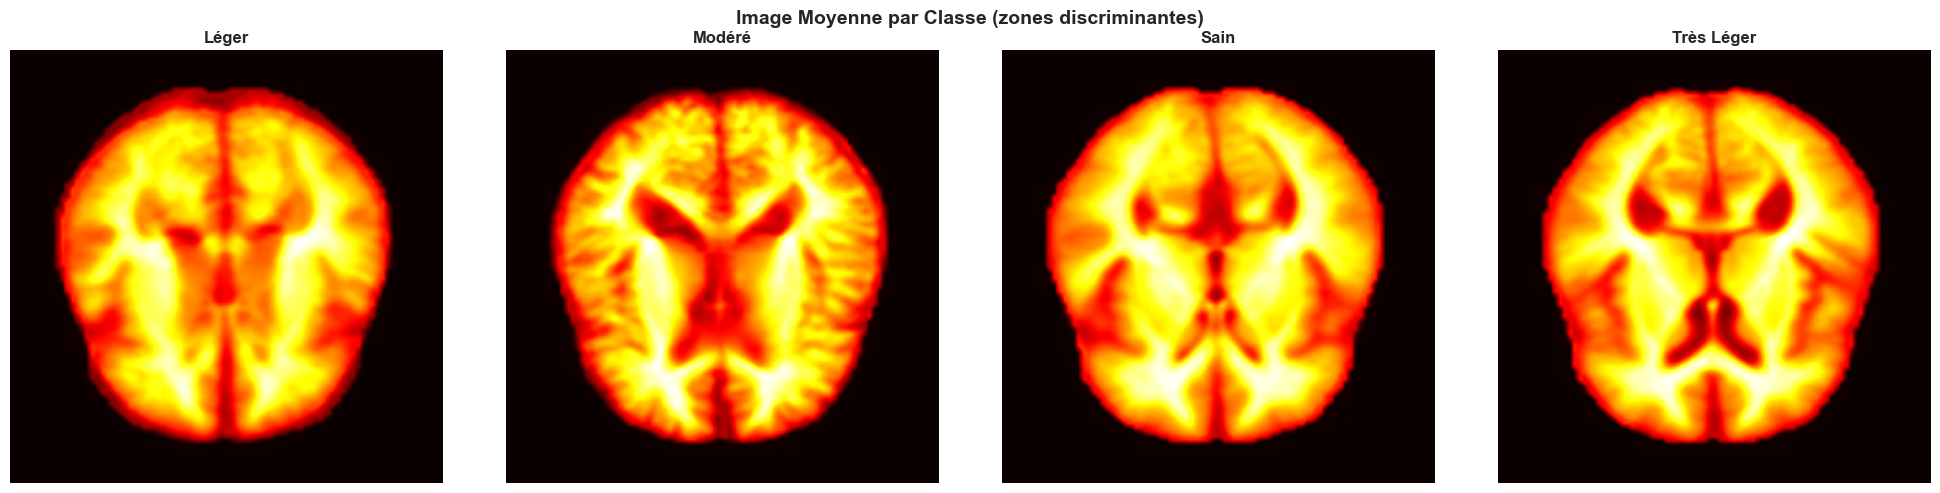

In [8]:
# ============================================================
# 3.5 Images moyennes par classe
# ============================================================

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Image Moyenne par Classe (zones discriminantes)", 
             fontsize=14, fontweight='bold')

mean_images = {}
for idx, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(TRAIN_DIR, class_name)
    sample_files = os.listdir(class_path)[:200]
    
    imgs = []
    for f in sample_files:
        try:
            img = Image.open(os.path.join(class_path, f)).convert('L').resize((IMG_SIZE, IMG_SIZE))
            imgs.append(np.array(img, dtype=np.float32))
        except:
            continue
    
    mean_img = np.mean(imgs, axis=0)
    mean_images[class_name] = mean_img
    
    axes[idx].imshow(mean_img, cmap='hot')
    axes[idx].set_title(f"{CLASS_LABELS_FR[class_name]}", fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('04_mean_images.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Prétraitement & Augmentation de Données

### Stratégie :
1. **Redimensionnement** : 224×224 pixels (compatibilité Transfer Learning)
2. **Normalisation** : Pixels → [0, 1]
3. **Augmentation (Train)** : Rotation, flip, zoom, shift pour réduire l'overfitting
4. **Class Weights** : Pondération inversement proportionnelle à la fréquence des classes
5. **Split Validation** : 80% train / 20% validation

In [9]:
# ============================================================
# 4.1 Création des générateurs de données
# ============================================================

# Augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2   # 20% pour validation
)

# Pas d'augmentation pour test (uniquement normalisation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Générateur Train
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED,
    color_mode='rgb'
)

# Générateur Validation
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED,
    color_mode='rgb'
)

# Générateur Test
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

print("=" * 60)
print("GÉNÉRATEURS DE DONNÉES")
print("=" * 60)
print(f"Train      : {train_generator.samples} images")
print(f"Validation : {val_generator.samples} images")
print(f"Test       : {test_generator.samples} images")
print(f"\nClasses mapping : {train_generator.class_indices}")
print("=" * 60)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
GÉNÉRATEURS DE DONNÉES
Train      : 5121 images
Validation : 1279 images
Test       : 6400 images

Classes mapping : {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [10]:
# ============================================================
# 4.2 Calcul des poids de classes (gestion du déséquilibre)
# ============================================================

# Méthode 1 : sklearn compute_class_weight
class_labels = train_generator.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights_array))

print("=" * 60)
print("POIDS DES CLASSES (inversement proportionnel à la fréquence)")
print("=" * 60)
for cls_idx, weight in class_weights.items():
    cls_name = list(train_generator.class_indices.keys())[cls_idx]
    print(f"  Classe {cls_idx} ({cls_name:25s}) : poids = {weight:.4f}")
print("=" * 60)
print("\n💡 Les classes sous-représentées (ex: ModerateDemented) auront")
print("   un poids plus élevé pour compenser le déséquilibre.")

POIDS DES CLASSES (inversement proportionnel à la fréquence)
  Classe 0 (MildDemented             ) : poids = 1.7856
  Classe 1 (ModerateDemented         ) : poids = 24.6202
  Classe 2 (NonDemented              ) : poids = 0.5001
  Classe 3 (VeryMildDemented         ) : poids = 0.7144

💡 Les classes sous-représentées (ex: ModerateDemented) auront
   un poids plus élevé pour compenser le déséquilibre.


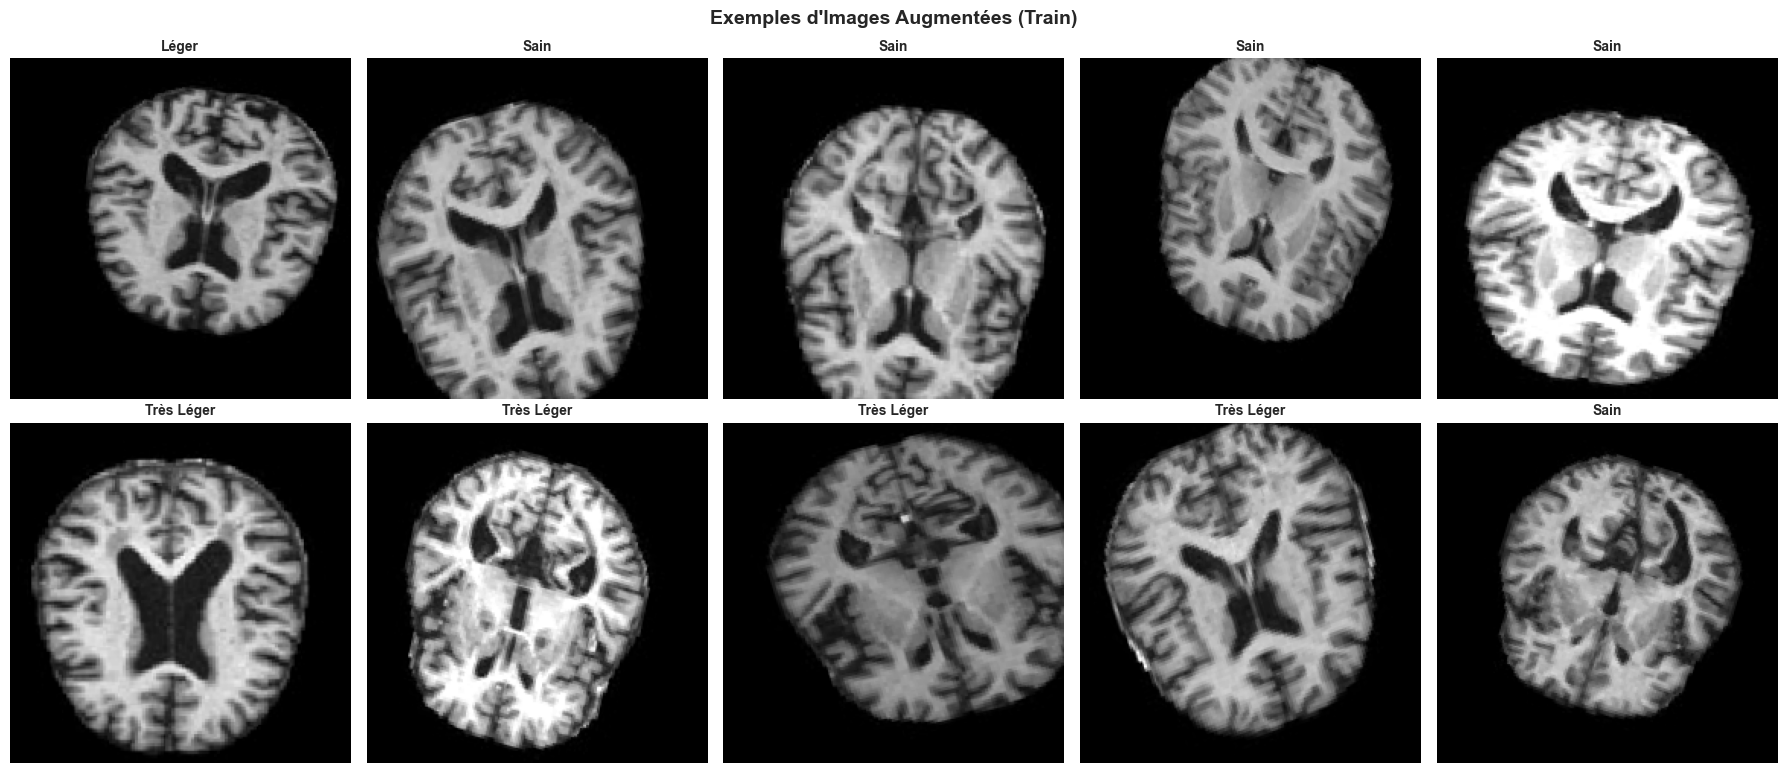

In [11]:
# ============================================================
# 4.3 Visualisation de l'augmentation de données
# ============================================================

# Prendre un batch d'images augmentées
sample_batch, sample_labels = next(train_generator)

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle("Exemples d'Images Augmentées (Train)", fontsize=14, fontweight='bold')

class_idx_to_name = {v: k for k, v in train_generator.class_indices.items()}

for i, ax in enumerate(axes.flat):
    if i < len(sample_batch):
        ax.imshow(sample_batch[i])
        label_idx = np.argmax(sample_labels[i])
        label_name = CLASS_LABELS_FR.get(class_idx_to_name[label_idx], '?')
        ax.set_title(f"{label_name}", fontsize=10, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('05_augmented_samples.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Résumé & Conclusions

### Résultats Clés
- Analyse approfondie du dataset d’IRM cérébrales pour la maladie d’Alzheimer (4 classes)
- Exploration de la structure des données et de la répartition des classes
- Mise en place d’un pipeline complet de prétraitement des images (redimensionnement, normalisation, visualisation)
- Identification des caractéristiques visuelles distinctives entre les différentes classes

### Défis Identifiés
- **Déséquilibre sévère** : la classe ModerateDemented est fortement sous-représentée
- **Confusion inter-classes** : difficulté de différenciation visuelle entre VeryMildDemented et MildDemented
- **Taille du dataset** : nombre d’images limité pour certaines classes, impactant l’analyse approfondie

### Pistes d'Amélioration
1. **Augmentation du dataset** : collecte de nouvelles données ou génération synthétique pour les classes rares
2. **Prétraitement avancé** : amélioration de la qualité des images (filtrage, amélioration du contraste)
3. **Sélection de régions d’intérêt (ROI)** : focalisation sur les zones cérébrales les plus pertinentes
4. **Méthodes d’explicabilité** : visualisation des zones clés pour une meilleure interprétation clinique


### Connexion avec les autres BOs
- **BO1** (Détection précoce) : Le pipeline tabulaire identifie les patients à risque
- **BO2** (Ce notebook) : Classification de la sévérité par IRM
- **BO3** (Recommandation) : Suggestions personnalisées basées sur le profil patient

---
**Projet TechHive — Thynk Unlimited | We Learn For The Future**

## 6. Pipeline ML Traditionnel : Aplatissement → Scaling → PCA → SVM

### Approche
Au lieu d'un réseau de neurones convolutif (CNN), nous utilisons ici un pipeline de Machine Learning classique :
1. **Aplatissement** — Conversion de chaque image 224×224×3 en vecteur 1D (150 528 features)
2. **Scaling** — `StandardScaler` pour centrer et normaliser les features
3. **PCA** — Réduction de dimensionnalité en retenant ≥ 95% de la variance
4. **Modélisation** — SVM avec noyau RBF et pondération des classes
5. **Évaluation** — Rapport de classification, matrice de confusion, précision par classe

> ⚠️ **Note mémoire** : Ce pipeline charge toutes les images en mémoire. Si vous rencontrez des problèmes de mémoire, une option de redimensionnement à 64×64 est disponible dans le code.

In [ ]:
# ============================================================
# 6.1 Extraction des images depuis les générateurs
# ============================================================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ------------------------------------------------------------------
# Option : réduire la taille des images si mémoire insuffisante
# Mettre USE_SMALL_IMAGES = True pour redimensionner à 64×64
# ------------------------------------------------------------------
USE_SMALL_IMAGES = False
SMALL_SIZE = 64

if USE_SMALL_IMAGES:
    # Recréer les générateurs avec des images plus petites
    _train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    _test_datagen  = ImageDataGenerator(rescale=1./255)
    
    _train_gen = _train_datagen.flow_from_directory(
        TRAIN_DIR, target_size=(SMALL_SIZE, SMALL_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', subset='training', shuffle=False, seed=SEED)
    _val_gen = _train_datagen.flow_from_directory(
        TRAIN_DIR, target_size=(SMALL_SIZE, SMALL_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', subset='validation', shuffle=False, seed=SEED)
    _test_gen = _test_datagen.flow_from_directory(
        TEST_DIR, target_size=(SMALL_SIZE, SMALL_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False)
    effective_size = SMALL_SIZE
else:
    # Recréer les générateurs SANS augmentation et shuffle=False pour extraction
    _train_datagen_noaug = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    _test_datagen_noaug  = ImageDataGenerator(rescale=1./255)
    
    _train_gen = _train_datagen_noaug.flow_from_directory(
        TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', subset='training', shuffle=False, seed=SEED)
    _val_gen = _train_datagen_noaug.flow_from_directory(
        TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', subset='validation', shuffle=False, seed=SEED)
    _test_gen = _test_datagen_noaug.flow_from_directory(
        TEST_DIR, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False)
    effective_size = IMG_SIZE

def extract_all_images(generator):
    """Extrait toutes les images et labels d'un générateur Keras."""
    generator.reset()
    images, labels = [], []
    steps = len(generator)
    for i in range(steps):
        batch_imgs, batch_lbls = next(generator)
        images.append(batch_imgs)
        labels.append(batch_lbls)
    return np.concatenate(images), np.concatenate(labels)

print("Extraction des images en cours...")
X_train_raw, y_train_raw = extract_all_images(_train_gen)
X_val_raw,   y_val_raw   = extract_all_images(_val_gen)
X_test_raw,  y_test_raw  = extract_all_images(_test_gen)

# Combiner train + validation pour le split PCA
X_trainval_raw = np.concatenate([X_train_raw, X_val_raw])
y_trainval_raw = np.concatenate([y_train_raw, y_val_raw])

# Convertir les labels one-hot en indices
y_train_idx = np.argmax(y_trainval_raw, axis=1)
y_test_idx  = np.argmax(y_test_raw, axis=1)

print(f"\n{'='*60}")
print("EXTRACTION DES IMAGES TERMINÉE")
print(f"{'='*60}")
print(f"Taille images : {effective_size}×{effective_size}")
print(f"Train+Val : {X_trainval_raw.shape[0]} images — shape: {X_trainval_raw.shape}")
print(f"Test      : {X_test_raw.shape[0]} images — shape: {X_test_raw.shape}")
print(f"\nDistribution train+val : {dict(zip(*np.unique(y_train_idx, return_counts=True)))}")
print(f"Distribution test      : {dict(zip(*np.unique(y_test_idx, return_counts=True)))}")

In [ ]:
# ============================================================
# 6.2 Aplatissement des images en vecteurs 1D
# ============================================================

n_pixels = effective_size * effective_size * 3  # 150,528 pour 224×224×3

X_train_flat = X_trainval_raw.reshape(X_trainval_raw.shape[0], -1)
X_test_flat  = X_test_raw.reshape(X_test_raw.shape[0], -1)

print(f"{'='*60}")
print("APLATISSEMENT DES IMAGES")
print(f"{'='*60}")
print(f"Image originale : ({effective_size}, {effective_size}, 3)")
print(f"Vecteur 1D      : ({n_pixels},)")
print(f"\nX_train_flat : {X_train_flat.shape}")
print(f"X_test_flat  : {X_test_flat.shape}")
print(f"Mémoire train : {X_train_flat.nbytes / 1e6:.1f} MB")
print(f"Mémoire test  : {X_test_flat.nbytes / 1e6:.1f} MB")

# Libérer la mémoire des images 3D
del X_trainval_raw, X_train_raw, X_val_raw, X_test_raw
import gc; gc.collect()

In [ ]:
# ============================================================
# 6.3 Scaling — StandardScaler
# ============================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

print(f"{'='*60}")
print("SCALING TERMINÉ (StandardScaler)")
print(f"{'='*60}")
print(f"Train — mean ≈ {X_train_scaled.mean():.6f}, std ≈ {X_train_scaled.std():.4f}")
print(f"Test  — mean ≈ {X_test_scaled.mean():.6f}, std ≈ {X_test_scaled.std():.4f}")

# Libérer les données non-scalées
del X_train_flat, X_test_flat
gc.collect()

In [ ]:
# ============================================================
# 6.4 PCA — Réduction de dimensionnalité (≥ 95% de variance)
# ============================================================

# Pour les images, le nombre de composantes est limité par min(n_samples, n_features)
# On utilise n_components=0.95 pour retenir 95% de la variance
n_samples_train = X_train_scaled.shape[0]
max_components = min(n_samples_train - 1, X_train_scaled.shape[1])

print(f"Nombre max de composantes possibles : {max_components}")
print(f"Application de PCA avec 95% de variance retenue...")
print(f"(Cela peut prendre quelques minutes pour des images haute résolution)\n")

pca = PCA(n_components=0.95, svd_solver='full', random_state=SEED)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print(f"{'='*60}")
print("PCA TERMINÉE")
print(f"{'='*60}")
print(f"Features originales :  {X_train_scaled.shape[1]:,}")
print(f"Composantes PCA :      {pca.n_components_}")
print(f"Variance retenue :     {pca.explained_variance_ratio_.sum():.4%}")
print(f"Réduction :            {pca.n_components_/X_train_scaled.shape[1]:.2%} des features")
print(f"\nX_train_pca shape : {X_train_pca.shape}")
print(f"X_test_pca shape  : {X_test_pca.shape}")

# Scree plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top 30 composantes
n_show = min(30, pca.n_components_)
axes[0].bar(range(1, n_show + 1), pca.explained_variance_ratio_[:n_show],
            color='steelblue', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Composante Principale')
axes[0].set_ylabel('Ratio de Variance Expliquée')
axes[0].set_title(f'Variance par Composante (Top {n_show})')

# Variance cumulée
cumvar = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, len(cumvar) + 1), cumvar, color='coral', linewidth=1.5)
axes[1].axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='Seuil 95%')
axes[1].set_xlabel('Nombre de Composantes')
axes[1].set_ylabel('Variance Cumulée')
axes[1].set_title('Variance Cumulée Expliquée')
axes[1].legend()
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

# Libérer les données scalées
del X_train_scaled, X_test_scaled
gc.collect()

In [ ]:
# ============================================================
# 6.5 Modélisation — SVM Multi-classes (noyau RBF)
# ============================================================

print("Entraînement du modèle SVM...")
print("(Cela peut prendre quelques minutes)\n")

svm_model = SVC(
    kernel='rbf',
    decision_function_shape='ovr',
    class_weight=class_weights,
    random_state=SEED,
    C=10,
    gamma='scale'
)
svm_model.fit(X_train_pca, y_train_idx)

y_pred = svm_model.predict(X_test_pca)

print(f"{'='*60}")
print("MODÈLE SVM ENTRAÎNÉ")
print(f"{'='*60}")
print(f"Kernel :           RBF")
print(f"Stratégie :        One-vs-Rest (OVR)")
print(f"C (régularisation): 10")
print(f"Poids de classes :  {class_weights}")
print(f"\nPrécision train :  {svm_model.score(X_train_pca, y_train_idx):.4f}")
print(f"Précision test  :  {accuracy_score(y_test_idx, y_pred):.4f}")

In [ ]:
# ============================================================
# 6.6 Évaluation — Rapport de classification & Matrice de confusion
# ============================================================

# Mapping des indices aux noms de classes (français)
class_idx_to_name = {v: k for k, v in _train_gen.class_indices.items()}
class_names_ordered = [class_idx_to_name[i] for i in range(NUM_CLASSES)]
class_labels_fr_ordered = [CLASS_LABELS_FR[name] for name in class_names_ordered]

# --- Rapport de classification ---
print("=" * 60)
print("RAPPORT DE CLASSIFICATION")
print("=" * 60)
print(f"\nPrécision globale : {accuracy_score(y_test_idx, y_pred):.4f}\n")
print(classification_report(
    y_test_idx, y_pred,
    target_names=class_labels_fr_ordered,
    digits=4
))

# --- Matrice de confusion ---
cm = confusion_matrix(y_test_idx, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Valeurs absolues
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_labels_fr_ordered,
            yticklabels=class_labels_fr_ordered)
axes[0].set_title('Matrice de Confusion (valeurs absolues)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Classe Réelle')
axes[0].set_xlabel('Classe Prédite')

# Valeurs normalisées (%)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Oranges', ax=axes[1],
            xticklabels=class_labels_fr_ordered,
            yticklabels=class_labels_fr_ordered)
axes[1].set_title('Matrice de Confusion (% par classe)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Classe Réelle')
axes[1].set_xlabel('Classe Prédite')

plt.tight_layout()
plt.show()

# --- Précision par classe (bar chart) ---
per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(class_labels_fr_ordered, per_class_acc, 
              color=['#2ecc71', '#e74c3c', '#3498db', '#f39c12'],
              edgecolor='black', alpha=0.85)

for bar, acc in zip(bars, per_class_acc):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
            f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('Précision (%)')
ax.set_title('Précision par Classe (SVM + PCA)', fontsize=13, fontweight='bold')
ax.set_ylim([0, 110])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# --- Résumé ---
print("\n" + "=" * 60)
print("RÉSUMÉ DU PIPELINE ML TRADITIONNEL")
print("=" * 60)
print(f"Images :           {effective_size}×{effective_size}×3")
print(f"Features (1D) :    {n_pixels:,}")
print(f"Composantes PCA :  {pca.n_components_}")
print(f"Variance retenue : {pca.explained_variance_ratio_.sum():.2%}")
print(f"Modèle :           SVM (RBF, C=10)")
print(f"Précision test :   {accuracy_score(y_test_idx, y_pred):.4f}")
print(f"\nPrécision par classe :")
for label, acc in zip(class_labels_fr_ordered, per_class_acc):
    print(f"  {label:15s}: {acc:.1f}%")
print("=" * 60)